# Binary classification

## Synthetic example

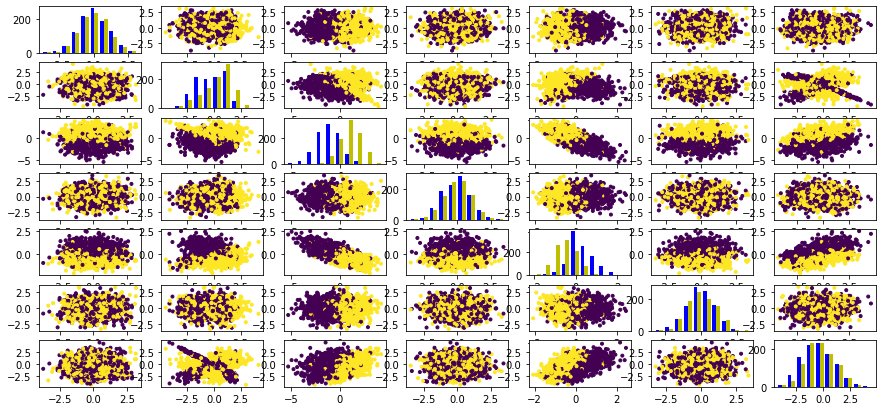

In [1]:
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pycalib.models import CalibratedClassifierCV

n_features = 7
X, y = datasets.make_classification(n_classes=2, n_samples=10000,
                                    n_clusters_per_class=3,
                                    n_features=n_features,
                                    n_informative=int(n_features/2),
                                    n_redundant=int(n_features/4),
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8,
                                                    random_state=42)

fig = plt.figure(figsize=(15, 7))
for i in range(n_features):
    for j in range(n_features):
        ax = fig.add_subplot(n_features, n_features, 1 + i + j*n_features)
        if i == j:
            x_per_class = [X_train[np.where(y_train == this_class)[0],i] for this_class in np.unique(y_train)]
            ax.hist(x_per_class, color=['b', 'y'])
        else:
            ax.scatter(X_train[:,i], X_train[:,j], c=y_train, marker='.')

# Reliability diagram

## Questions

- Reliability diagram in 1 class only considers positive class. While it is possible to create the multiclass by flattening the binarized true labels and predictions. This makes the histogram in the multiclass case much prominent in the lower end of the predicted values. Would this be fine?
- If we addopt the previously proposed method for multiclass, does it make sense to use the same approach for binary problems by flattening the 2 class binarized matrix, instead of ussing only the positive class?

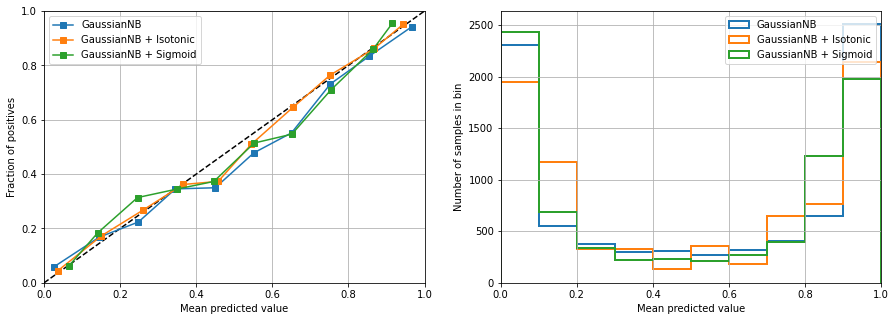

In [2]:
from sklearn.preprocessing import label_binarize

def plot_reliability_diagram(X, y, estimators, n_bins=10, histogram=True):
    if histogram:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
    else:
        fig = plt.figure(figsize=(7, 5))
        ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot([0, 1], [0, 1], "k--")
    
    classes = np.unique(y)
    n_classes = len(classes)
    if n_classes > 2:
        y = label_binarize(y, classes=classes)
        y = y.flatten()
        
    for clf, name in estimators:
        prob_pos = clf.predict_proba(X)
        if n_classes > 2:
            prob_pos = prob_pos.flatten()
        else:
            prob_pos = prob_pos[:, 1]

        fraction_of_positives, mean_predicted_value = calibration_curve(y, prob_pos, n_bins=n_bins)
        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                         label=name)
        if histogram:
            ax2.hist(prob_pos, range=(0, 1), bins=n_bins, label=name,
                     histtype="step", lw=2)
    ax1.legend()
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_xlabel('Mean predicted value')
    ax1.set_ylabel('Fraction of positives')
    ax1.grid()
    if histogram:
        ax2.legend()
        ax2.set_xlim([0, 1])
        ax2.set_xlabel('Mean predicted value')
        ax2.set_ylabel('Number of samples in bin')
        ax2.grid()
    return fig

estimators = [(GaussianNB(), 'GaussianNB'),
              (CalibratedClassifierCV(GaussianNB(), cv=4, method='isotonic'), 'GaussianNB + Isotonic'),
              (CalibratedClassifierCV(GaussianNB(), cv=4, method='sigmoid'), 'GaussianNB + Sigmoid')
             ]

for clf, name in estimators:
    clf.fit(X_train, y_train)
    
_ = plot_reliability_diagram(X_test, y_test, estimators, histogram=True)

# Calibration map

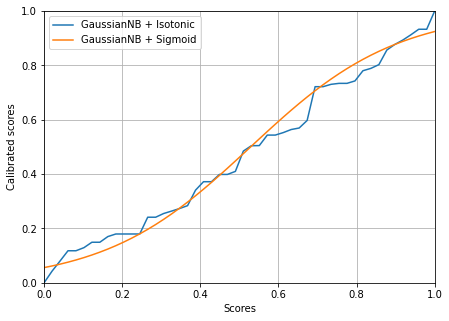

In [3]:
scores_linspace = np.linspace(0, 1, 50)
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
for clf, name in estimators:
    if not hasattr(clf, 'calibrated_classifiers_'):
        continue
    classifiers = clf.calibrated_classifiers_
    calibrated = np.mean([cla.calibrators_[0].predict(scores_linspace) for cla in classifiers], axis=0)
    ax.plot(scores_linspace, calibrated, label=name)
ax.legend()
ax.set_xlabel('Scores')
ax.set_ylabel('Calibrated scores')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()

# Reliability diagram discrepancy

## Questions

- There are at least 4 ways to create the red gaps. Between (1) the mean predicted scores inside the bin, or (2) the center of the bin and the expected proportion of positives in the center of the bin. Similarly, the end of the gap could be to (3) the expected proportions in the center of the bin, or to (4) the point in which a vertical line from the predicted mean value inside the bin intersects with the diagonal.

/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/miquel/git/uob/classifier-calibration/hands_on/lib/PyCalib/pycalib/visualisations/__init__.py:153: RuntimeWarning: Mean of empty slice
  pred_mean[i] = np.nanmean(p_pred[bin_indices])


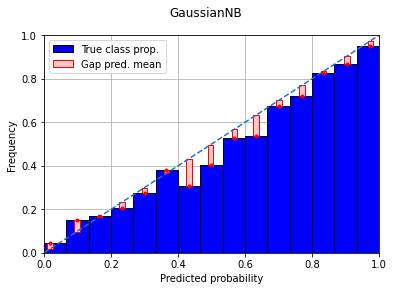

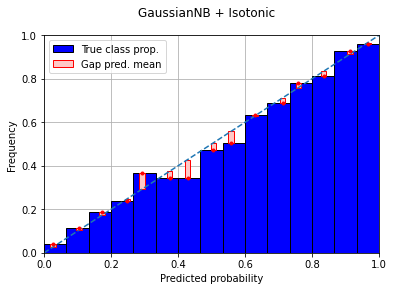

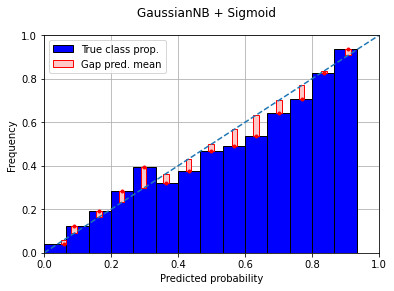

In [4]:
from pycalib.visualisations import plot_multiclass_reliability_diagram_gaps

for clf, name in estimators:
    est_scores = clf.predict_proba(X_test)
    fig = plot_multiclass_reliability_diagram_gaps(y_test, est_scores[:, 1], n_bins=15)
    fig.suptitle(name)

# Ternary classification

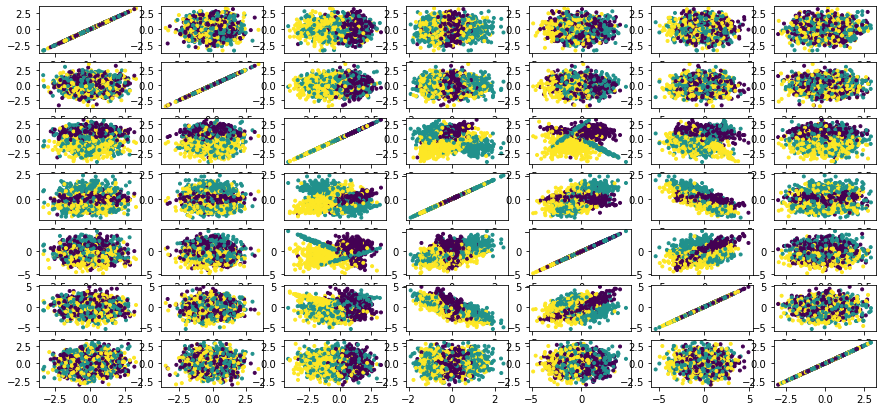

In [5]:
n_features = 7
X, y = datasets.make_classification(n_classes=3, n_samples=10000,
                                    n_clusters_per_class=2,
                                    n_features=n_features,
                                    n_informative=int(n_features/2),
                                    n_redundant=int(n_features/4),
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8,
                                                    random_state=42)

fig = plt.figure(figsize=(15, 7))
for i in range(n_features):
    for j in range(n_features):
        ax = fig.add_subplot(n_features, n_features, 1 + i + j*n_features)
        plt.scatter(X_train[:,i], X_train[:,j], c=y_train, marker='.')

# Reliability diagram

## Question

- Can be implemented by flattening all the classes and predictions into an array (current implementation). We could also perform the confidence reliability diagram. Should we implement that one?

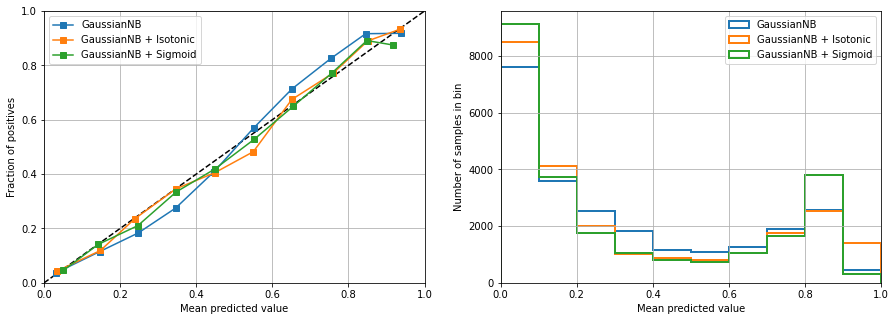

In [6]:
estimators = [(GaussianNB(), 'GaussianNB'),
              (CalibratedClassifierCV(GaussianNB(), cv=4, method='isotonic'), 'GaussianNB + Isotonic'),
              (CalibratedClassifierCV(GaussianNB(), cv=4, method='sigmoid'), 'GaussianNB + Sigmoid')
             ]

for clf, name in estimators:
    clf.fit(X_train, y_train)
    
_ = plot_reliability_diagram(X_test, y_test, estimators, histogram=True)

# Calibration map



In [7]:
from pycalib.visualisations.barycentric import draw_calibration_map
from pycalib.visualisations.barycentric import get_mesh_bc

from dirichletcal import FullDirichletCalibrator, FixedDiagonalDirichletCalibrator, DirichletCalibrator

estimators = [(GaussianNB(), 'GaussianNB'),
              (CalibratedClassifierCV(GaussianNB(), cv=4, method=FullDirichletCalibrator), 'GaussianNB + Isotonic'),
              (CalibratedClassifierCV(GaussianNB(), cv=4, method=FixedDiagonalDirichletCalibrator), 'GaussianNB + Sigmoid')
             ]

for clf, name in estimators:
    clf.fit(X_train, y_train)


P_bc_grid = get_mesh_bc(subdiv=5)

for clf, name in estimators:
    if not hasattr(clf, 'calibrated_classifiers_'):
        continue
    classifiers = clf.calibrated_classifiers_
    calibrated = np.mean([cla.calibrators_[0].predict(P_bc_grid) for cla in classifiers], axis=0)
    draw_calibration_map(P_bc_grid, calibrated)


ValueError: method should be None, "sigmoid", "isotonic", "beta", "beta2" or "beta05". Got <class 'dirichletcal.calib.fulldirichlet.FullDirichletCalibrator'>.

# Multiclass classification

In [ ]:
from pycalib.visualisations import plot_multiclass_reliability_discrepancy_diagram

for clf, name in estimators:
    est_scores = clf.predict_proba(X_test)
    fig = plot_multiclass_reliability_discrepancy_diagram(y_test, est_scores[:, 1], n_bins=15)
    fig.suptitle(name)